In [6]:
# Imports
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F


from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset, TensorDataset

from torchsummary import summary
import torchvision as tv
import torchvision.transforms as T
from imageio import imread

import copy

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline as backend_inline

backend_inline.set_matplotlib_formats("svg")


#### Pytorch device specific configuration ###

# Pytorch Gpu Configuration for Cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Pytorch Gpu Configuration for directml(AMD GPU)
# import torch_directml

# device = torch_directml.device()

# Set default device
torch.set_default_device(device)

In [7]:
# Import the model
vggnet = tv.models.vgg19(pretrained=True)

# Freeze all layers
for p in vggnet.parameters():
    p.requires_grad_(False)

# Set to evalution mode
vggnet.eval()

/home/kumar/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kumar/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [8]:
# Summery of the model
# summary(vggnet)

In [9]:
# Push the model to the GPU
vggnet.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [10]:
# Import the content and style images
img4content = imread(
    "https://upload.wikimedia.org/wikipedia/commons/6/61/De_nieuwe_vleugel_van_het_Stedelijk_Museum_Amsterdam.jpg"
)
img4style = imread(
    "https://upload.wikimedia.org/wikipedia/commons/c/c5/Edvard_Munch%2C_1893%2C_The_Scream%2C_oil%2C_tempera_and_pastel_on_cardboard%2C_91_x_73_cm%2C_National_Gallery_of_Norway.jpg"
)

# Initialize the target image and random numbers
img4target = np.random.randint(low=0, high=255, size=img4content.shape, dtype=np.uint8)

print(img4content)
print(img4target)
print(img4style.shape)

/tmp/ipykernel_3001/193544799.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img4content = imread(
/tmp/ipykernel_3001/193544799.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img4style = imread(


[[[ 50  62  50]
  [ 78  91  73]
  [ 74  87  70]
  ...
  [  4  96 179]
  [  7 104 185]
  [  0  98 176]]

 [[ 70  83  65]
  [ 59  72  55]
  [ 67  79  65]
  ...
  [  2  97 179]
  [  3 100 181]
  [  4  99 181]]

 [[ 70  83  63]
  [ 86 100  75]
  [ 83  97  74]
  ...
  [  0  99 180]
  [  1  98 179]
  [  7  99 182]]

 ...

 [[ 71  66  62]
  [ 68  67  63]
  [ 71  68  63]
  ...
  [ 47  48  42]
  [ 49  50  44]
  [ 44  43  38]]

 [[ 71  66  63]
  [ 63  62  57]
  [ 70  67  62]
  ...
  [ 45  46  40]
  [ 45  46  40]
  [ 46  45  40]]

 [[ 68  63  60]
  [ 67  66  61]
  [ 74  71  66]
  ...
  [ 45  46  40]
  [ 44  45  39]
  [ 47  46  41]]]
[[[114 136 180]
  [189  55 194]
  [ 61 205  50]
  ...
  [178 143 238]
  [ 67 174  71]
  [232 223 238]]

 [[229  95  87]
  [ 12  34 216]
  [198 244 127]
  ...
  [120 243 235]
  [126 184  77]
  [ 78  49 182]]

 [[ 37 121 184]
  [120 167 253]
  [245  65 201]
  ...
  [229  88 179]
  [ 17 175 212]
  [222 136  40]]

 ...

 [[178  25 135]
  [176  58 227]
  [ 92 206 114]
  ..

In [11]:
## Reducing image dimention as bigger image will take forever to train

# Create transform
Ts = T.Compose([
    T.ToTensor(),
    T.Resize(256),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# apply them to the images ("unsqueeze" to make them a 4D tensor) and push to GPU
img4content = Ts(img4content).unsqueeze(0).to(device)
img4style = Ts(img4style).unsqueeze(0).to(device)
img4target = Ts(img4target).unsqueeze(0).to(device)

print(img4content.shape)
print(img4target.shape)
print(img4style.shape)

torch.Size([1, 3, 256, 458])
torch.Size([1, 3, 256, 458])
torch.Size([1, 3, 317, 256])


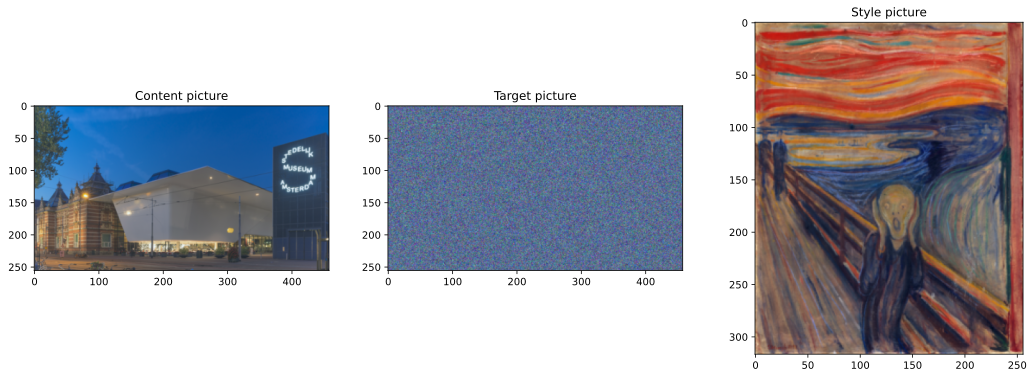

In [12]:
# Let's have a look at the "before" pics
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

pic = img4content.cpu().squeeze().numpy().transpose((1, 2, 0))
pic = (pic - np.min(pic)) / (np.max(pic) - np.min(pic))
ax[0].imshow(pic)
ax[0].set_title("Content picture")

pic = img4target.cpu().squeeze().numpy().transpose((1, 2, 0))
pic = (pic - np.min(pic)) / (np.max(pic) - np.min(pic))
ax[1].imshow(pic)
ax[1].set_title("Target picture")

pic = img4style.cpu().squeeze().numpy().transpose((1, 2, 0))
pic = (pic - np.min(pic)) / (np.max(pic) - np.min(pic))
ax[2].imshow(pic)
ax[2].set_title("Style picture")

plt.show()

In [14]:
# Function to extract image features map activations
def getFeatureMapActs(img, net):

    # Initialize feature maps as a list
    featuremaps = []
    featurenames = []

    convLayerIdx = 0

    # Loop through all layers in the features block
    for layernum in range(len(net.features)):

        # Print out info from this layer
        # print(layernum, net.features[layernum])

        # Process the image through this layer
        img = net.features[layernum](img)

        # Store the image if it's a conv2d layer
        if 'Conv2d' in str(net.features[layernum]):
            featuremaps.append(img)
            featuremaps.append('ConvLayer_' + str(convLayerIdx))
            convLayerIdx += 1
    
    return featuremaps, featurenames


